In [1]:
%%time

# NOTE: 5m40s

# Navigate to the content directory in Colab
%cd /content

# Clone the specific branch of ComfyUI from GitHub
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI

# Navigate to the cloned directory
%cd /content/TotoroUI

# Install necessary Python packages quietly
!pip install -q torchsde einops diffusers accelerate xformers==0.0.27.post2

# Install aria2 package for downloading multiple files concurrently
!apt -y install -qq aria2

# Download required model files using aria2 with concurrency
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors


/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 14652, done.
remote: Total 14652 (delta 0), reused 0 (delta 0), pack-reused 14652 (from 1)
Receiving objects: 100% (14652/14652), 25.53 MiB | 13.34 MiB/s, done.
Resolving deltas: 100% (9796/9796), done.
/content/TotoroUI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.9 MB/s 

In [2]:
import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management
from IPython.display import display

/usr/local/lib/python3.10/dist-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/usr/local/lib/python3.10/dist-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [3]:
%%time

# NOTE: 1m34s

# Initialize the loaders using the model mappings
DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()


with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

# Define your closestNumber function
def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
def generate_image(positive_prompt, width=1024, height=1024, seed=0, steps=20, sampler_name="euler", scheduler="simple"):
    with torch.inference_mode():
        if seed == 0:
            seed = random.randint(0, 18446744073709551615)
        print(f"Using seed: {seed}")

        # Encode the positive prompt
        cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
        cond = [[cond, {"pooled_output": pooled}]]

        # Generate noise and guider
        noise = RandomNoise.get_noise(seed)[0]
        guider = BasicGuider.get_guider(unet, cond)[0]

        # Select sampler and get sigmas
        sampler = KSamplerSelect.get_sampler(sampler_name)[0]
        sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]

        # Generate latent image
        latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]

        # Perform sampling
        sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)

        # Clear cache
        model_management.soft_empty_cache()

        # Decode the sampled image and save it
        decoded = VAEDecode.decode(vae, sample)[0].detach()
        decoded = VAEDecode.decode(vae, sample)[0].detach()
        Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")

        img = Image.fromarray(np.array(decoded * 255, dtype=np.uint8)[0])
        img.save("/content/flux.png")
        return img

Using seed: 8036291794203916671


  0%|          | 0/20 [00:00<?, ?it/s]

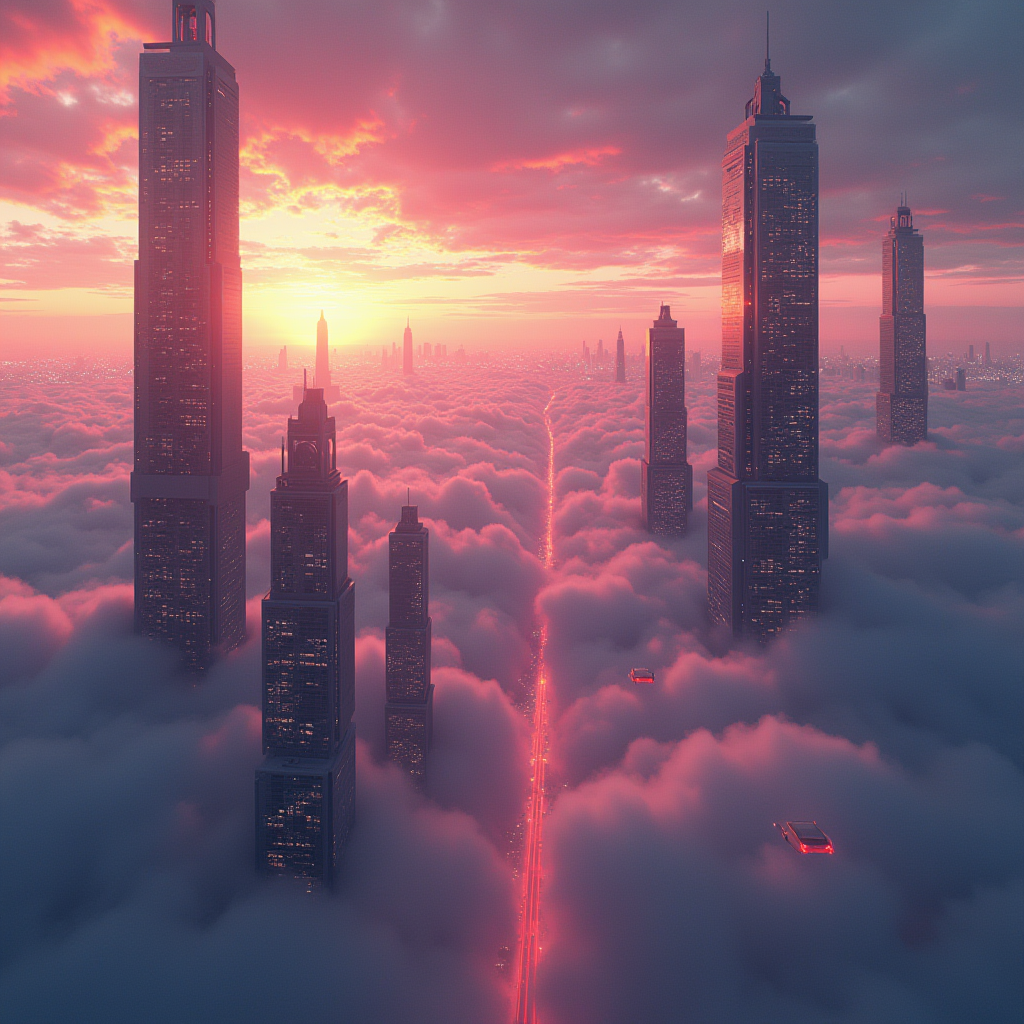

In [5]:
%%time

# NOTE: 7m51s

# Usage example:
positive_prompt = "A futuristic city floating above the clouds, with towering glass skyscrapers reflecting the colors of a vibrant sunset, flying cars zipping between the buildings, and a glowing neon skyline."
image = generate_image(positive_prompt)
display(image)

Using seed: 7682938817164254750


  0%|          | 0/20 [00:00<?, ?it/s]

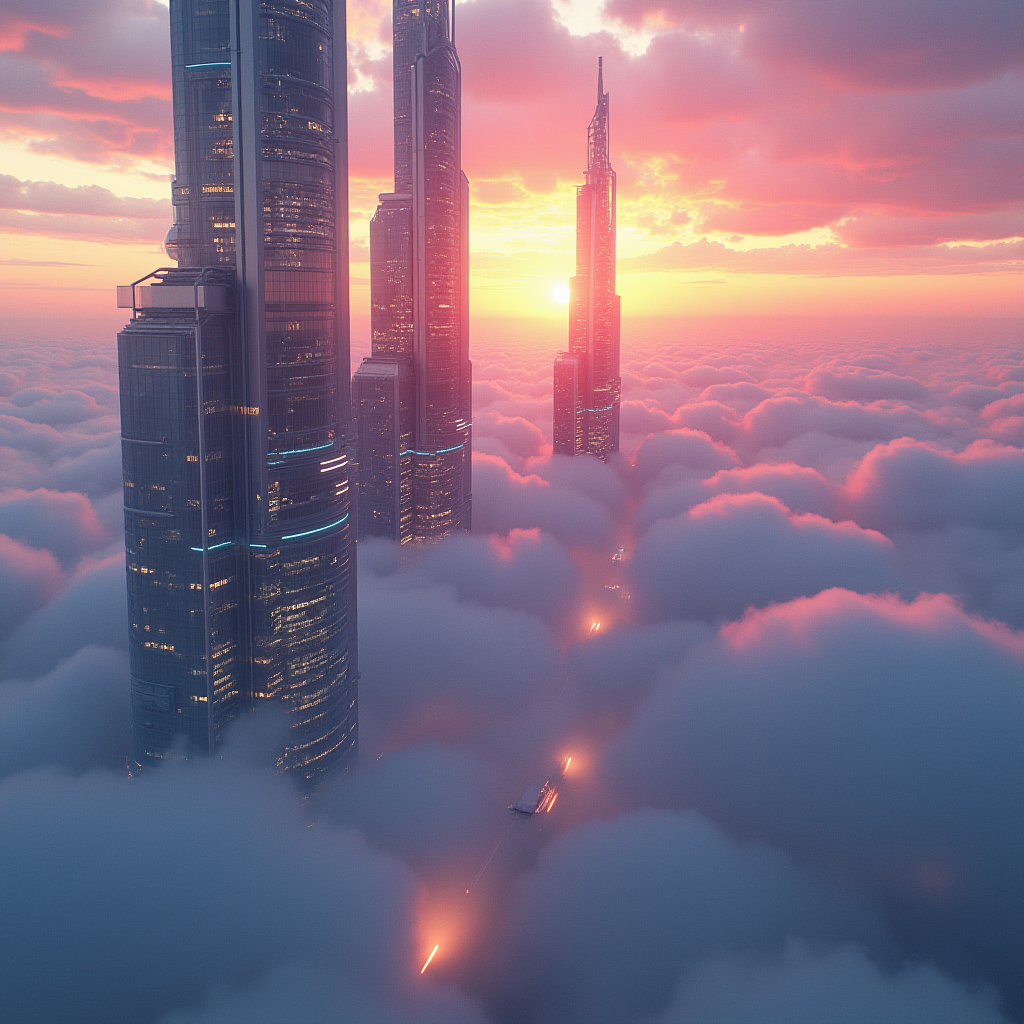

In [ ]:
# Usage example:
positive_prompt = "A futuristic city floating above the clouds, with towering glass skyscrapers reflecting the colors of a vibrant sunset, flying cars zipping between the buildings, and a glowing neon skyline."
image = generate_image(positive_prompt)
display(image)

Using seed: 7479327390474414690


  0%|          | 0/20 [00:00<?, ?it/s]

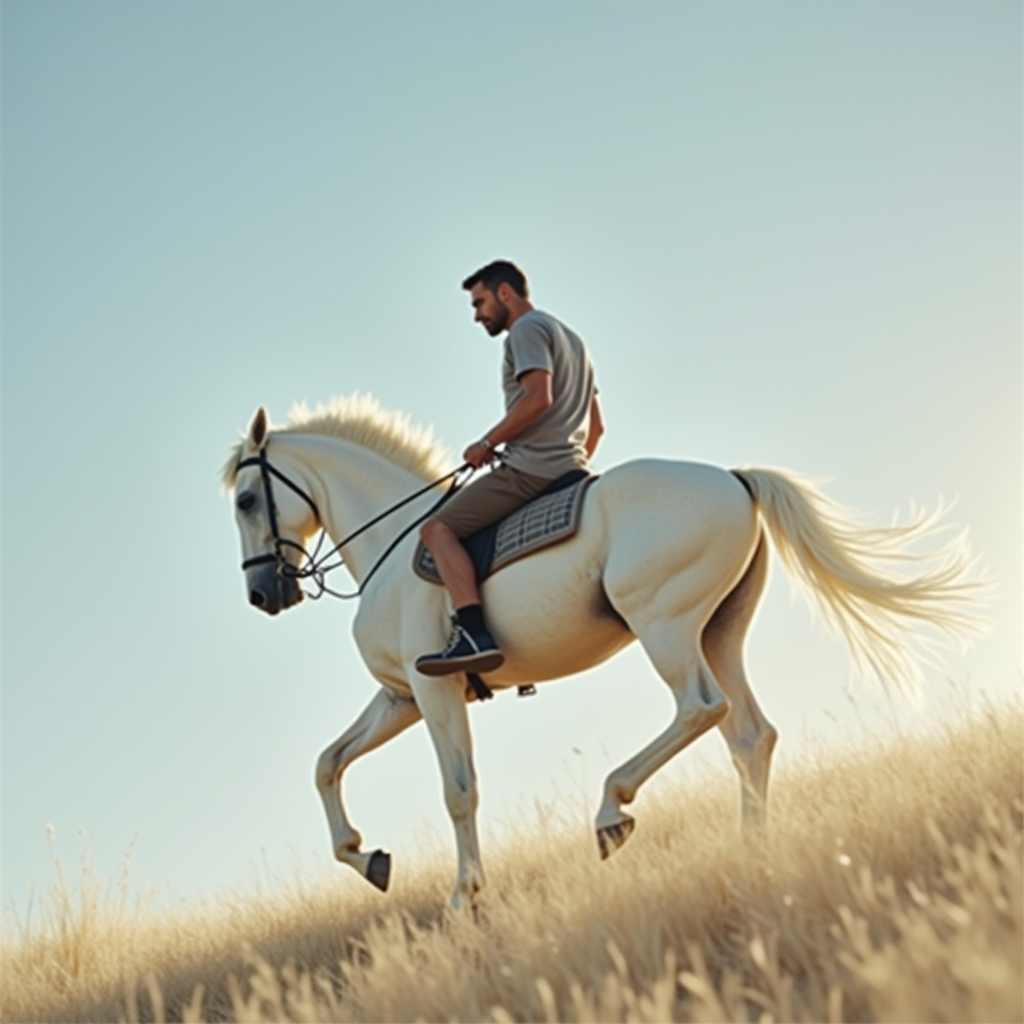

CPU times: user 5min 24s, sys: 2min 23s, total: 7min 48s
Wall time: 7min 50s


In [6]:
%%time

# NOTE:

# Example of how to call the function
image = generate_image("A man is riding a white horse in the sky.")
display(image)

Using seed: 4141597922837269905


  0%|          | 0/20 [00:00<?, ?it/s]

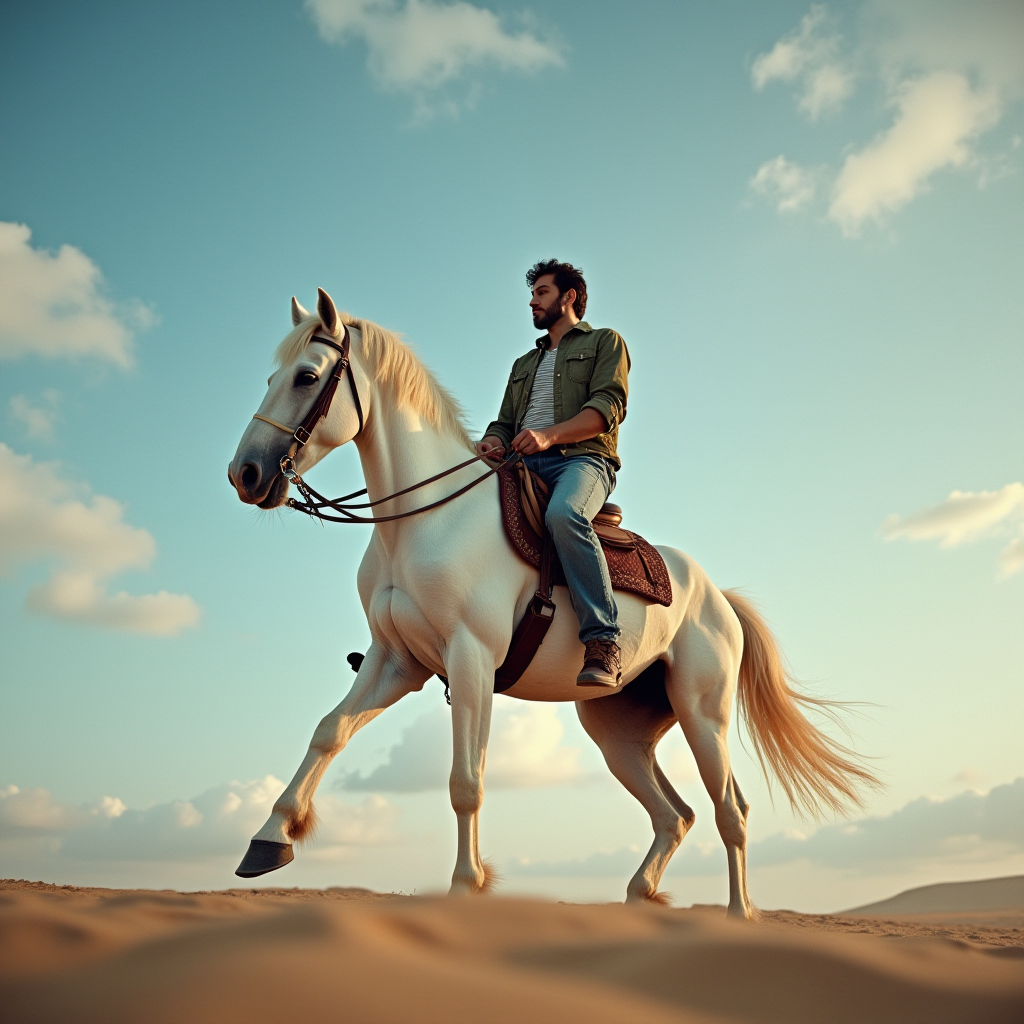

In [ ]:
# Example of how to call the function
image = generate_image("A man is riding a white horse in the sky.")
display(image)

In [ ]:
%%time

# NOTE:

# Example of how to call the function
image = generate_image("A man is riding a white horse in the sky.")
display(image)

Using seed: 1703270109570603772


  0%|          | 0/20 [00:00<?, ?it/s]

Using seed: 17511855609511395474


  0%|          | 0/20 [00:00<?, ?it/s]

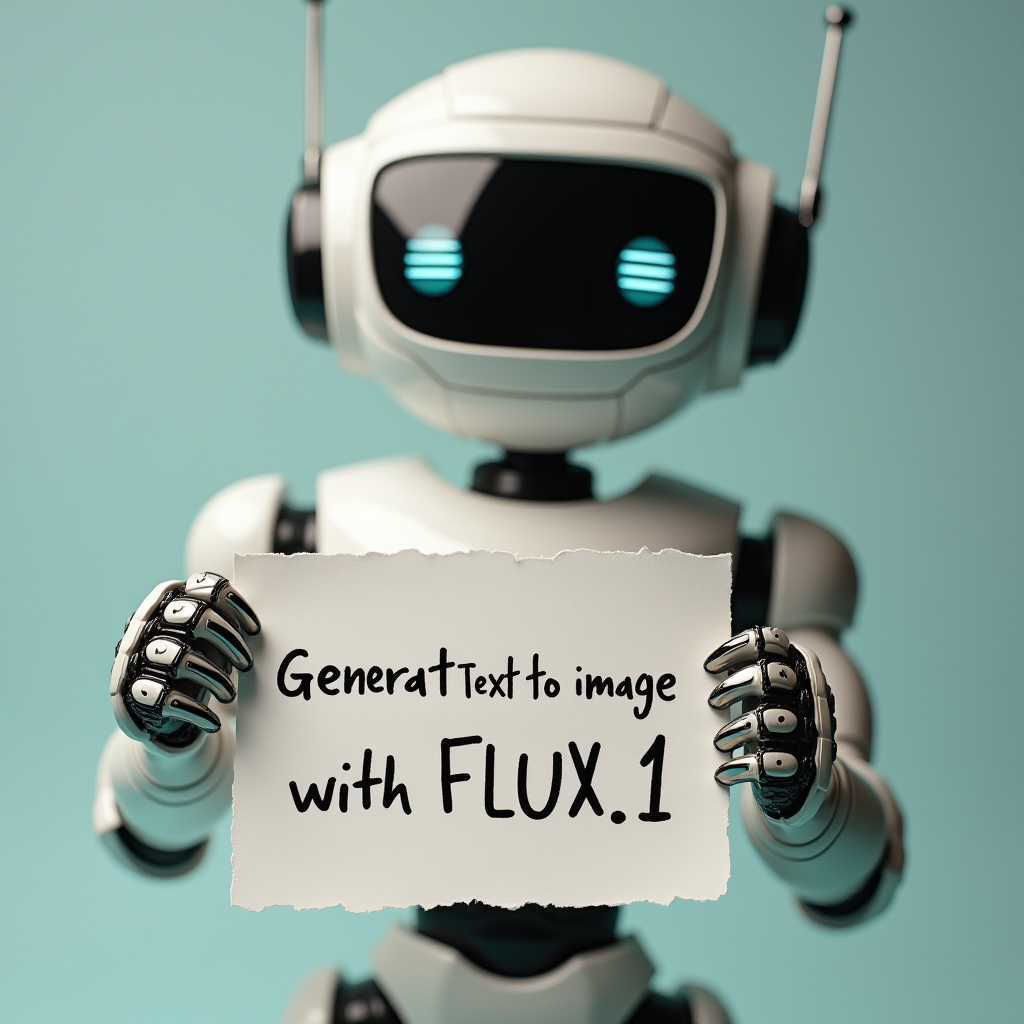

In [ ]:
# Example of how to call the function
image = generate_image("A robot is holding a piece of paper that reads 'Generate text to image with FLUX.1'.")
display(image)